In [8]:
#  Install & Import
!pip install transformers torch scikit-learn pandas matplotlib wordcloud seaborn -q

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

In [9]:
#  Load Data
print("Loading data...")
df = pd.read_csv('/content/amazonreviews.tsv', sep='\t', on_bad_lines='skip')
print(f"Original: {len(df)} rows")
display(df.head())

Loading data...
Original: 10000 rows


label                                             review
0   pos  Stuning even for the non-gamer: This sound tra...
1   pos  The best soundtrack ever to anything.: I'm rea...
2   pos  Amazing!: This soundtrack is my favorite music...
3   pos  Excellent Soundtrack: I truly like this soundt...
4   pos  Remember, Pull Your Jaw Off The Floor After He...

In [10]:
# Clean Data
df.drop_duplicates(inplace=True)
print(f"After removing duplicates: {len(df)}")

def clean_text(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()

df['clean'] = df['review'].apply(clean_text)
df['label'] = df['label'].map({'pos': 1, 'neg': 0})
print("Cleaning done!")

After removing duplicates: 10000
Cleaning done!


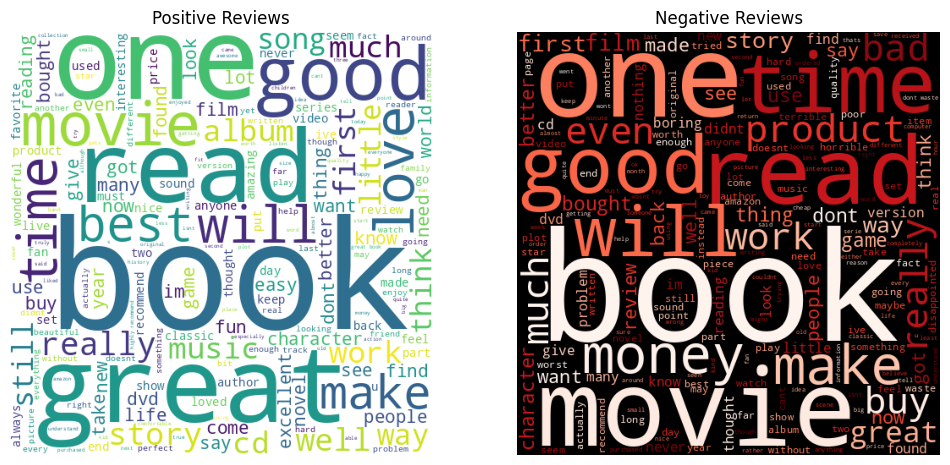

In [11]:
# EDA - Word Cloud
pos_text = " ".join(df[df['label']==1]['clean'])
neg_text = " ".join(df[df['label']==0]['clean'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=500, height=500, background_color='white').generate(pos_text))
plt.title('Positive Reviews')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=500, height=500, background_color='black', colormap='Reds').generate(neg_text))
plt.title('Negative Reviews')
plt.axis('off')
plt.show()

In [12]:
#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df['clean'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 8000, Test: 2000


In [13]:
# TF-IDF + Logistic (Baseline)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.858
F1-Score: 0.8579373503715139


In [14]:
# BERT Prediction
classifier = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment-latest')

def predict_sentiment(text):
    result = classifier(text)[0]
    return "Positive" if result['label'] == 'LABEL_2' else "Negative"

# Test
print(predict_sentiment("This is the best product ever!"))
print(predict_sentiment("Worst purchase, broke immediately."))

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


Negative
Negative
